Anomaly detection using autoencoders involves training the autoencoder on a dataset containing only normal or non-anomalous data. The autoencoder learns to reconstruct these normal instances accurately. When the trained autoencoder is later applied to data that might contain anomalies, it will likely fail to reconstruct the anomalous data accurately, resulting in a higher reconstruction error. This reconstruction error can be used as a metric to identify anomalies.

Steps for Anomaly Detection with Autoencoders:

1. Data Preparation: Collect and preprocess the dataset, ensuring that the training data consists only of normal (non-anomalous) instances.

2. Build the Autoencoder: Design the autoencoder neural network with an encoder and decoder. The encoder compresses the input data into a lower-dimensional latent space, and the decoder reconstructs the original data from this latent representation.

3. Train the Autoencoder: Train the autoencoder on the normal data, so it learns to reconstruct these instances with minimal error.

4. Calculate Reconstruction Error: After training, pass both normal and anomalous data through the autoencoder and calculate the reconstruction error for each instance.

5. Set a Threshold: Determine a threshold for the reconstruction error above which data points are considered anomalies. This threshold can be chosen based on the distribution of reconstruction errors on a validation set.

6. Detect Anomalies: Use the threshold to classify data points as normal or anomalous based on their reconstruction error.

The idea is quite straightforward:

Due to the bottleneck architecture of the neural network, it is forced to learn a condensed representation from which to reproduce the original input.
We feed it only normal transactions, which it will learn to reproduce with high fidelity.
As a consequence, if a fraud transaction is sufficiently distinct from normal transactions, the auto-encoder will have trouble reproducing it with its learned weights, and the subsequent reconstruction loss will be high.
Anything above a specific loss (treshold) will be flagged as anomalous and thus labeled as fraud.

# Preprocessing

### Import Libraries & set Random Seeds

In [14]:
# read & manipulate data
import pandas as pd 
import numpy as np
import tensorflow as tf

# visualisations
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='whitegrid', context='notebook')
%matplotlib notebook
%matplotlib inline

# misc
import random as rn

# load the dataset
df = pd.read_csv('creditcard.csv')

# manual parameters
RANDOM_SEED = 42
TRAINING_SAMPLE = 200000
VALIDATE_SIZE = 0.2

# setting random seeds for libraries to ensure reproducibility
np.random.seed(RANDOM_SEED)
rn.seed(RANDOM_SEED)
tf.random.set_seed(42)

### Renaming columns

In [5]:
# let's quickly convert the columns to lower case and rename the Class column 
# so as to not cause syntax errors
df.columns = map(str.lower, df.columns)
df.rename(columns={'class': 'label'}, inplace=True)

# print first 5 rows to get an initial impression of the data we're dealing with
df.head()

,time,v1,v2,v3,v4,v5,v6,v7,v8,v9,...,v21,v22,v23,v24,v25,v26,v27,v28,amount,label
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [6]:
# add a negligible amount to avoid taking the log of 0
df['log10_amount'] = np.log10(df.amount + 0.00001)

# Visualising clusters with t-SNE

t-Distributed Stochastic Neighbor Embedding (t-SNE)

From the sklearn documentation:

t-SNE is a tool to visualize high-dimensional data. It converts similarities between data points to joint probabilities and tries to minimize the Kullback-Leibler divergence between the joint probabilities of the low-dimensional embedding and the high-dimensional data. t-SNE has a cost function that is not convex, i.e. with different initializations we can get different results.

In plain English, most certainly oversimplifying matters: t-SNE is a dimensionality reduction technique used for visualisations of complex datasets. It maps clusters in high-dimensional data to a two- or three dimensional plane so we can get an idea of how easy it will be to discriminate between classes. It does this by trying to keep the distance between data points in lower dimensions proportional to the probability that these data points are neighbours in the higher dimensions.

### Undersampling the non-fraud

To keep the computation time low, let's feed t-SNE only a small subsample (undersampling the clean transactions).


In [7]:
# manual parameter 
RATIO_TO_FRAUD = 15

# dropping redundant columns
df = df.drop(['time', 'amount'], axis=1)

# splitting by class
fraud = df[df.label == 1]
clean = df[df.label == 0]

# undersample clean transactions
clean_undersampled = clean.sample(
    int(len(fraud) * RATIO_TO_FRAUD),
    random_state=RANDOM_SEED
)

# concatenate with fraud transactions into a single dataframe
visualisation_initial = pd.concat([fraud, clean_undersampled])
column_names = list(visualisation_initial.drop('label', axis=1).columns)

# isolate features from labels 
features, labels = visualisation_initial.drop('label', axis=1).values, \
                   visualisation_initial.label.values

In [8]:
print(f"""The non-fraud dataset has been undersampled from {len(clean):,} to {len(clean_undersampled):,}.
This represents a ratio of {RATIO_TO_FRAUD}:1 to fraud.""")

The non-fraud dataset has been undersampled from 284,315 to 7,380.
This represents a ratio of 15:1 to fraud.


### t-SNE output

In [15]:
from sklearn.manifold import TSNE
from mpl_toolkits.mplot3d import Axes3D

def tsne_scatter(features, labels, dimensions=2, save_as='graph.png'):
    if dimensions not in (2, 3):
        raise ValueError('tsne_scatter can only plot in 2d or 3d (What are you? An alien that can visualise >3d?). Make sure the "dimensions" argument is in (2, 3)')

    # t-SNE dimensionality reduction
    features_embedded = TSNE(n_components=dimensions, random_state=RANDOM_SEED).fit_transform(features)
    
    # initialising the plot
    fig, ax = plt.subplots(figsize=(8,8))
    
    # counting dimensions
    if dimensions == 3: ax = fig.add_subplot(111, projection='3d')

    # plotting data
    ax.scatter(
        *zip(*features_embedded[np.where(labels==1)]),
        marker='o',
        color='r',
        s=2,
        alpha=0.7,
        label='Fraud'
    )
    ax.scatter(
        *zip(*features_embedded[np.where(labels==0)]),
        marker='o',
        color='g',
        s=2,
        alpha=0.3,
        label='Clean'
    )

    # storing it to be displayed later
    plt.legend(loc='best')
    plt.savefig(save_as);
    plt.show;

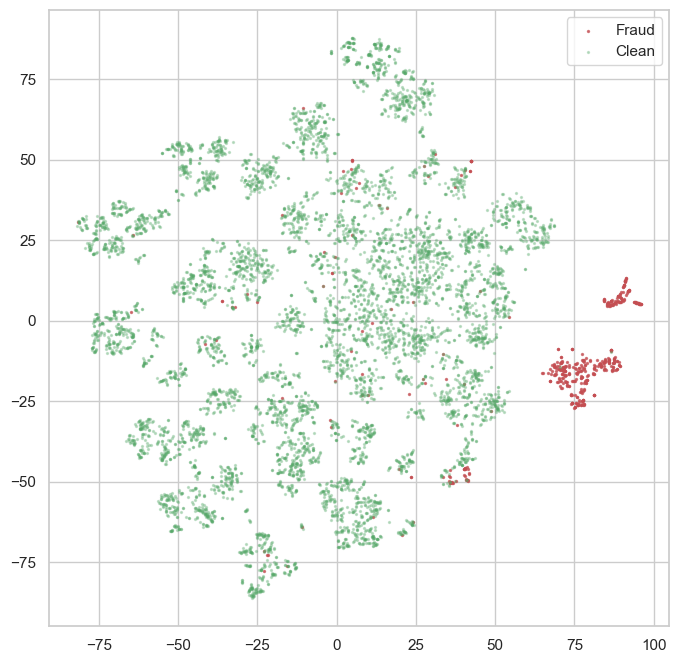

In [16]:
tsne_scatter(features, labels, dimensions=2, save_as='tsne_initial_2d.png')

# Train/Validate/Test split

Our auto-encoder will only train on transactions that were normal. What's left over will be combined with the fraud set to form our test sample.
1. Training: only non-fraud
  
   Split into:
   
     Actual training of our autoencoder
   
     Validation of the neural network's ability to generalize
   
3. Testing : mix of fraud and non-fraud

   Treated like new data
   
   Attempt to locate outliers

     Compute reconstruction loss

     Apply threshold

In [17]:
print(f"""Shape of the datasets:
    clean (rows, cols) = {clean.shape}
    fraud (rows, cols) = {fraud.shape}""")

Shape of the datasets:
    clean (rows, cols) = (284315, 30)
    fraud (rows, cols) = (492, 30)


In [19]:
# shuffle our training set
clean = clean.sample(frac=1).reset_index(drop=True)

# training set: exlusively non-fraud transactions
X_train = clean.iloc[:TRAINING_SAMPLE].drop('label', axis=1)

# testing  set: the remaining non-fraud + all the fraud 
X_test = pd.concat([clean.iloc[TRAINING_SAMPLE:], fraud]).sample(frac=1).reset_index(drop=True)


In [20]:
print(f"""Our testing set is composed as follows:

{X_test.label.value_counts()}""")


Our testing set is composed as follows:

label
0    84315
1      492
Name: count, dtype: int64


In [21]:
from sklearn.model_selection import train_test_split

# train // validate - no labels since they're all clean anyway
X_train, X_validate = train_test_split(X_train, 
                                       test_size=VALIDATE_SIZE, 
                                       random_state=RANDOM_SEED)

# manually splitting the labels from the test df
X_test, y_test = X_test.drop('label', axis=1).values, X_test.label.values

In [22]:
print(f"""Shape of the datasets:
    training (rows, cols) = {X_train.shape}
    validate (rows, cols) = {X_validate.shape}
    holdout  (rows, cols) = {X_test.shape}""")

Shape of the datasets:
    training (rows, cols) = (160000, 29)
    validate (rows, cols) = (40000, 29)
    holdout  (rows, cols) = (84807, 29)


# Building our pipeline

In [23]:
from sklearn.preprocessing import Normalizer, MinMaxScaler
from sklearn.pipeline import Pipeline

# configure our pipeline
pipeline = Pipeline([('normalizer', Normalizer()),
                     ('scaler', MinMaxScaler())])

In [24]:
pipeline.fit(X_train)

Pipeline(steps=[('normalizer', Normalizer()), ('scaler', MinMaxScaler())])

In [25]:
# transform the training and validation data with these parameters
X_train_transformed = pipeline.transform(X_train)
X_validate_transformed = pipeline.transform(X_validate)

### Before & After

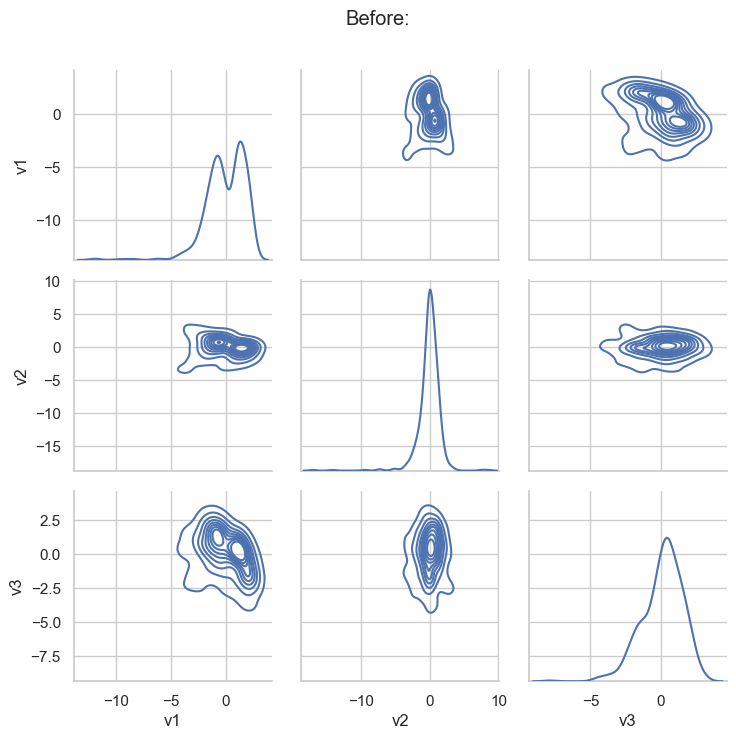

In [26]:
g = sns.PairGrid(X_train.iloc[:,:3].sample(600, random_state=RANDOM_SEED))
plt.subplots_adjust(top=0.9)
g.fig.suptitle('Before:')
g.map_diag(sns.kdeplot)
g.map_offdiag(sns.kdeplot);

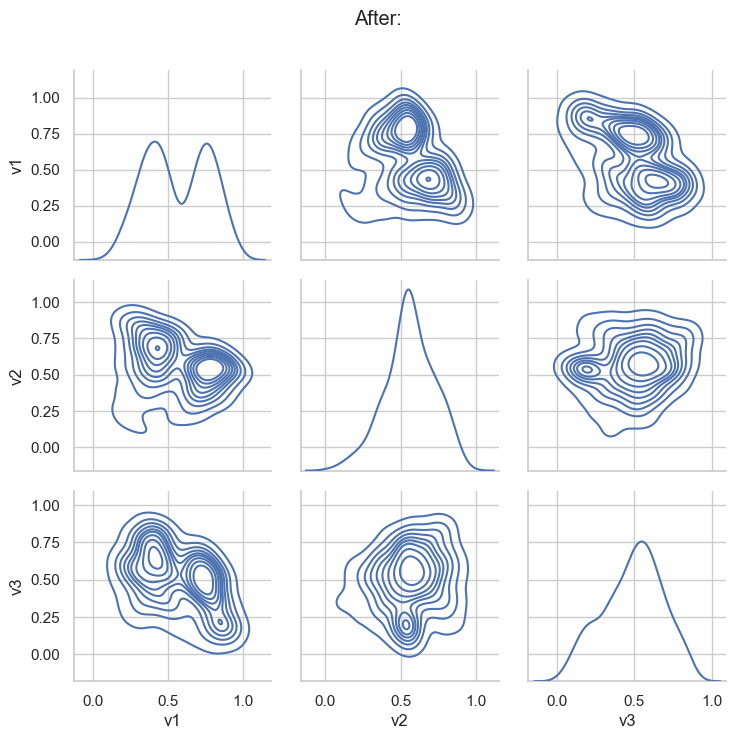

In [27]:
g = sns.PairGrid(pd.DataFrame(X_train_transformed, columns=column_names).iloc[:,:3].sample(600, random_state=RANDOM_SEED))
plt.subplots_adjust(top=0.9)
g.fig.suptitle('After:')
g.map_diag(sns.kdeplot)
g.map_offdiag(sns.kdeplot);

We can tell the data is slightly more uniform and proportionally distributed.
The ranges were also shrunk to fit between 0 and 1.

# Training the auto-encoder

### Architecture of our model

In [28]:
# data dimensions // hyperparameters 
input_dim = X_train_transformed.shape[1]
BATCH_SIZE = 256
EPOCHS = 100

# https://keras.io/layers/core/
autoencoder = tf.keras.models.Sequential([
    
    # deconstruct / encode
    tf.keras.layers.Dense(input_dim, activation='elu', input_shape=(input_dim, )), 
    tf.keras.layers.Dense(16, activation='elu'),
    tf.keras.layers.Dense(8, activation='elu'),
    tf.keras.layers.Dense(4, activation='elu'),
    tf.keras.layers.Dense(2, activation='elu'),
    
    # reconstruction / decode
    tf.keras.layers.Dense(4, activation='elu'),
    tf.keras.layers.Dense(8, activation='elu'),
    tf.keras.layers.Dense(16, activation='elu'),
    tf.keras.layers.Dense(input_dim, activation='elu')
    
])

# https://keras.io/api/models/model_training_apis/
autoencoder.compile(optimizer="adam", 
                    loss="mse",
                    metrics=["acc"])

# print an overview of our model
autoencoder.summary();

D:\Anaconda\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 29)                  │             870 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 16)                  │             480 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 8)                   │             136 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 4)                   │              36 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 2)                   │              10 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 4)                   │              12 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 8)                   │              40 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 16)                  │             144 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 29)                  │             493 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,221 (8.68 KB)

 Trainable params: 2,221 (8.68 KB)

 Non-trainable params: 0 (0.00 B)

### Callbacks
Continue as long as the model is reducing the training loss.
Save only the weights for the model with the lowest validation loss, though.
Get graphical insights with Tensorboard.

In [31]:
from datetime import datetime

# current date and time
yyyymmddHHMM = datetime.now().strftime('%Y%m%d%H%M')

# new folder for a new run
log_subdir = f'{yyyymmddHHMM}_batch{BATCH_SIZE}_layers{len(autoencoder.layers)}'

# define our early stopping
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=0.0001,
    patience=10,
    verbose=1, 
    mode='min',
    restore_best_weights=True
)

save_model = tf.keras.callbacks.ModelCheckpoint(
    filepath='autoencoder_best_weights.keras',
    save_best_only=True,
    monitor='val_loss',
    verbose=0,
    mode='min'
)

# callbacks argument only takes a list
cb = [early_stop, save_model]

### Training 

In [32]:
history = autoencoder.fit(
    X_train_transformed, X_train_transformed,
    shuffle=True,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=cb,
    validation_data=(X_validate_transformed, X_validate_transformed)
)

Epoch 1/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - acc: 0.1659 - loss: 0.0677 - val_acc: 0.2510 - val_loss: 0.0173
Epoch 2/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - acc: 0.2500 - loss: 0.0170 - val_acc: 0.2641 - val_loss: 0.0155
Epoch 3/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - acc: 0.2970 - loss: 0.0150 - val_acc: 0.3339 - val_loss: 0.0146
Epoch 4/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - acc: 0.3352 - loss: 0.0145 - val_acc: 0.3399 - val_loss: 0.0142
Epoch 5/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - acc: 0.3347 - loss: 0.0141 - val_acc: 0.3232 - val_loss: 0.0139
Epoch 6/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - acc: 0.3257 - loss: 0.0138 - val_acc: 0.3295 - val_loss: 0.0138
Epoch 7/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - acc: 0.3332 - loss: 0.0137 - val_acc: 0.3368 - val_loss: 0.0137
Epoch 8/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - acc: 0.3427 - loss: 0.0136 - val_acc: 0.3442 - val_loss: 0.0131
Epoch 9/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/

# Reconstructions
We apply the transformation pipeline to our test set.
Then, we pass the data through the trained autoencoder.

In [33]:
# transform the test set with the pipeline fitted to the training set
X_test_transformed = pipeline.transform(X_test)

# pass the transformed test set through the autoencoder to get the reconstructed result
reconstructions = autoencoder.predict(X_test_transformed)

   1/2651 ━━━━━━━━━━━━━━━━━━━━ 4:33 103ms/step

D:\Anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but Normalizer was fitted with feature names
  warnings.warn(


2651/2651 ━━━━━━━━━━━━━━━━━━━━ 3s 968us/step


In [34]:
# calculating the mean squared error reconstruction loss per row in the numpy array
mse = np.mean(np.power(X_test_transformed - reconstructions, 2), axis=1)

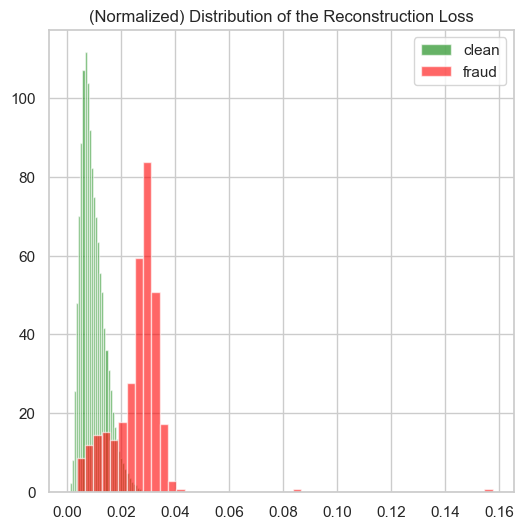

In [38]:
clean = mse[y_test==0]
fraud = mse[y_test==1]

fig, ax = plt.subplots(figsize=(6,6))

ax.hist(clean, bins=50, density=True, label="clean", alpha=.6, color="green")
ax.hist(fraud, bins=50, density=True, label="fraud", alpha=.6, color="red")

plt.title("(Normalized) Distribution of the Reconstruction Loss")
plt.legend()
plt.show()

Very promising! Although some transactions seem to fool the autoencoder, the fraudulent transactions clearly have a distinguishing element in their data that sets them apart from clean ones.

# Setting a threshold for classification

### Unsupervised

In [39]:
THRESHOLD = 3

def mad_score(points):
    """https://www.itl.nist.gov/div898/handbook/eda/section3/eda35h.htm """
    m = np.median(points)
    ad = np.abs(points - m)
    mad = np.median(ad)
    
    return 0.6745 * ad / mad

z_scores = mad_score(mse)
outliers = z_scores > THRESHOLD

In [40]:
print(f"Detected {np.sum(outliers):,} outliers in a total of {np.size(z_scores):,} transactions [{np.sum(outliers)/np.size(z_scores):.2%}].")

Detected 1,935 outliers in a total of 84,807 transactions [2.28%].


### Supervised

In [41]:
from sklearn.metrics import (confusion_matrix, 
                             precision_recall_curve)

# get (mis)classification
cm = confusion_matrix(y_test, outliers)

# true/false positives/negatives
(tn, fp, 
 fn, tp) = cm.flatten()

In [42]:
print(f"""The classifications using the MAD method with threshold={THRESHOLD} are as follows:
{cm}

% of transactions labeled as fraud that were correct (precision): {tp}/({fp}+{tp}) = {tp/(fp+tp):.2%}
% of fraudulent transactions were caught succesfully (recall):    {tp}/({fn}+{tp}) = {tp/(fn+tp):.2%}""")

The classifications using the MAD method with threshold=3 are as follows:
[[82759  1556]
 [  113   379]]

% of transactions labeled as fraud that were correct (precision): 379/(1556+379) = 19.59%
% of fraudulent transactions were caught succesfully (recall):    379/(113+379) = 77.03%


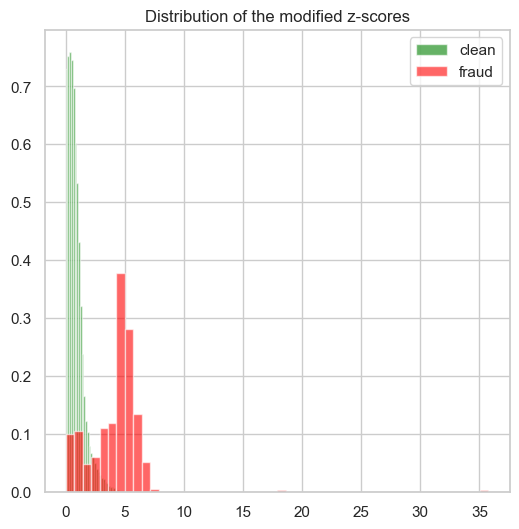

In [43]:
clean = z_scores[y_test==0]
fraud = z_scores[y_test==1]

fig, ax = plt.subplots(figsize=(6,6))

ax.hist(clean, bins=50, density=True, label="clean", alpha=.6, color="green")
ax.hist(fraud, bins=50, density=True, label="fraud", alpha=.6, color="red")

plt.title("Distribution of the modified z-scores")
plt.legend()
plt.show()

# Latent Space¶
It is always interesting to look at the compressed representation our neural network devised.

### Encoder
Let's build the encoder that gets us to the bottleneck. We take the layers from our autoencoder.

In [44]:
encoder = tf.keras.models.Sequential(autoencoder.layers[:5])
encoder.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 29)                  │             870 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 16)                  │             480 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 8)                   │             136 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 4)                   │              36 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 2)                   │              10 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,532 (5.98 KB)

 Trainable params: 1,532 (5.98 KB)

 Non-trainable params: 0 (0.00 B)

### Undersampling¶
Consistent with the previous t-sne visualisation, let's undersample the clean transactions.

In [45]:
# taking all the fraud, undersampling clean
fraud = X_test_transformed[y_test==1]
clean = X_test_transformed[y_test==0][:len(fraud) * RATIO_TO_FRAUD, ]

# combining arrays & building labels
features = np.append(fraud, clean, axis=0)
labels = np.append(np.ones(len(fraud)),
                   np.zeros(len(clean)))

# getting latent space representation
latent_representation = encoder.predict(features)

print(f'Clean transactions downsampled from {len(X_test_transformed[y_test==0]):,} to {len(clean):,}.')
print('Shape of latent representation:', latent_representation.shape)

246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 852us/step
Clean transactions downsampled from 84,315 to 7,380.
Shape of latent representation: (7872, 2)


### Visualising the Latent Space

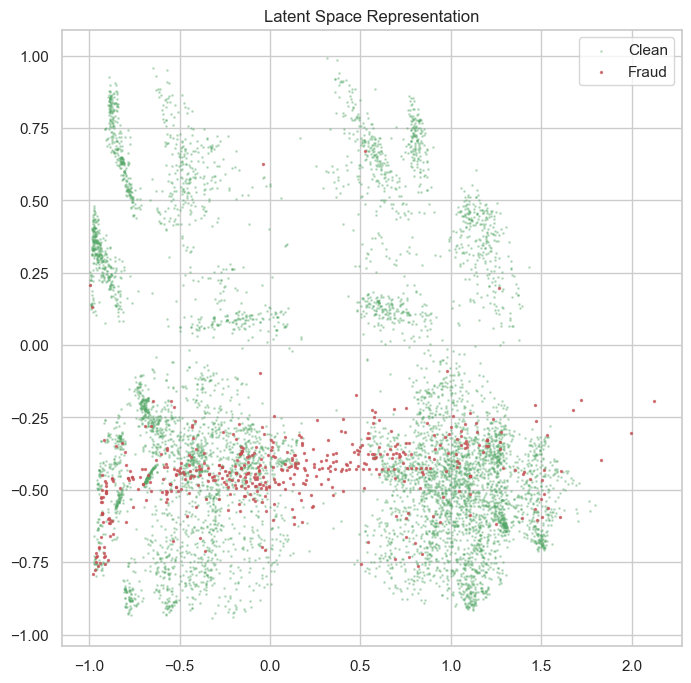

In [46]:
X = latent_representation[:,0]
y = latent_representation[:,1]

# plotting
plt.subplots(figsize=(8, 8))
plt.scatter(X[labels==0], y[labels==0], s=1, c='g', alpha=0.3, label='Clean')
plt.scatter(X[labels==1], y[labels==1], s=2, c='r', alpha=0.7, label='Fraud')

# labeling
plt.legend(loc='best')
plt.title('Latent Space Representation')

# saving & displaying
plt.savefig('latent_representation_2d');
plt.show()

# Conclusion
We could already tell from our misclassifications that the network was not able to generalize perfectly. However, we must not forget that our model was trained never having seen a single fraud case! In that regard, its performance is decent. It illustrates the power of autoencoders as anomaly detection tools.